In [1]:
import time
import enum
from typing import Union
import warnings

from boruta import BorutaPy
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import seaborn as sb
from scipy.stats import sigmaclip
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical
from sklearn_genetic.callbacks import ProgressBar


warnings.filterwarnings("ignore")

## Объявление функций

In [2]:
FONT_SIZE = 40
RUSSIAN_ALPHABET = [chr(i) for i in range(1072, 1104)]

N_ESTIMATORS = [10, 25, 50, 100, 500, 1000, 2000, 3000, 4000, 5000]
MAX_DEPTH = list(range(2, 11))

SCORING = "roc_auc"
STATE = 42

ModelClassifier = Union[
    SVC,
    KNeighborsClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
]

In [3]:
class MethodNames(enum.Enum):
    GRID = "Grid Search"
    RANDOMIZED = "Randomized Search"
    BAYES = "Bayes Search"
    GENETIC = "Genetic Algorithm"

In [4]:
class ModelNames(enum.Enum):
    SVC_MODEL = "SVC"
    KNN_MODEL = "k-Nearest Neighbors"
    GRADIENT_BOOSTING_CLASSIFIER = "Gradient Boosting"
    RANDOM_FOREST_CLASSIFIER = "Random Forest"

In [5]:
class BaseHyperParametersModel:

    def __init__(
        self,
        method_name: str,
        model_name: str,
        model_instance: ModelClassifier,
        model_parameters: dict[str, list],
    ) -> None:
        self.method_name = method_name
        self.model_name = model_name
        self.model_instance = model_instance
        self.model_parameters = model_parameters
        self.roc_auc_score = []
        self.precision_score = []
        self.recall_score = []
        self.f1_score = []
        self.accuracy = []
        self.predicted = []
        self.best_model = None
        self.time_learning = 0.0

    def get_results(self) -> None:
        "Вывод результатов."
        print(f"Метод: {self.method_name}")
        print(f"Время обучения: {self.time_learning:.4f} секунд")
        print(f"F1 score: {self.f1_score:.4f}")
        print(f"Accuracy score: {self.accuracy_score:.4f}")
        print(f"ROC-AUC score: {self.roc_auc_score:.4f}")
        print(f"Recall score: {self.recall_score:.4f}")
        print(f"Precision score: {self.precision_score:.4f}")
        getting_parameters = self.best_model.get_params()
        print("Параметры модели:")
        for key in self.model_parameters:
            print(f"\t{key}: {getting_parameters[key]}")


In [6]:
class GridSearchHyperParametersModel(BaseHyperParametersModel):
    
    def fit_model(
        self,
        x_train: pd.DataFrame,
        x_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
    ) -> None:
        """Поиск подходящих параметров и вывод информации о модели."""
        gs = GridSearchCV(
            self.model_instance,
            self.model_parameters,
            cv=5,
            n_jobs=-1,
            scoring=SCORING,
        )
        start = time.time()
        gs.fit(x_train, y_train)
        self.time_learning = time.time() - start
        self.best_model = gs.best_estimator_
        self.predict_proba = self.best_model.predict_proba(x_test)[:, 1]
        self.predict = self.best_model.predict(x_test)
        self.precision_score = precision_score(y_test, self.predict)
        self.recall_score = recall_score(y_test, self.predict)
        self.f1_score = f1_score(y_test, self.predict)
        self.accuracy_score = accuracy_score(y_test, self.predict)
        self.roc_auc_score = roc_auc_score(y_test, self.predict_proba)


In [7]:
class RandomizedSearchHyperParametersModel(BaseHyperParametersModel):

    def fit_model(
        self,
        x_train: pd.DataFrame,
        x_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
    ) -> None:
        """Поиск подходящих параметров и вывод информации о модели."""
        gs = RandomizedSearchCV(
            self.model_instance,
            self.model_parameters,
            cv=5,
            n_jobs=-1,
            scoring=SCORING,
            random_state=STATE,
        )
        start = time.time()
        gs.fit(x_train, y_train)
        self.time_learning = time.time() - start
        self.best_model = gs.best_estimator_
        self.predict_proba = self.best_model.predict_proba(x_test)[:, 1]
        self.predict = self.best_model.predict(x_test)
        self.precision_score = precision_score(y_test, self.predict)
        self.recall_score = recall_score(y_test, self.predict)
        self.f1_score = f1_score(y_test, self.predict)
        self.accuracy_score = accuracy_score(y_test, self.predict)
        self.roc_auc_score = roc_auc_score(y_test, self.predict_proba)


In [8]:
class BayesSearchHyperParametersModel(BaseHyperParametersModel):

    def fit_model(
        self,
        x_train: pd.DataFrame,
        x_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
    ) -> None:
        """Поиск подходящих параметров и вывод информации о модели."""
        gs = BayesSearchCV(
            self.model_instance,
            self.model_parameters,
            cv=5,
            n_jobs=-1,
            scoring=SCORING,
            random_state=STATE,
        )
        start = time.time()
        gs.fit(x_train, y_train)
        self.time_learning = time.time() - start
        self.best_model = gs.best_estimator_
        self.predict_proba = self.best_model.predict_proba(x_test)[:, 1]
        self.predict = self.best_model.predict(x_test)
        self.precision_score = precision_score(y_test, self.predict)
        self.recall_score = recall_score(y_test, self.predict)
        self.f1_score = f1_score(y_test, self.predict)
        self.accuracy_score = accuracy_score(y_test, self.predict)
        self.roc_auc_score = roc_auc_score(y_test, self.predict_proba)


In [9]:
class GeneticAlgorithmsHyperParametersModel(BaseHyperParametersModel):

    def fit_model(
        self,
        x_train: pd.DataFrame,
        x_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
    ) -> None:
        """Поиск подходящих параметров и вывод информации о модели."""
        gs = GASearchCV(
            estimator=self.model_instance,
            param_grid=self.model_parameters,
            generations=10,
            population_size=6,
            elitism=True,
            tournament_size=3,
            cv=5,
            n_jobs=-1,
            scoring=SCORING,
            verbose=False,
        )
        start = time.time()
        gs.fit(x_train, y_train)
        self.time_learning = time.time() - start
        self.best_model = gs.best_estimator_
        self.predict_proba = self.best_model.predict_proba(x_test)[:, 1]
        self.predict = self.best_model.predict(x_test)
        self.precision_score = precision_score(y_test, self.predict)
        self.recall_score = recall_score(y_test, self.predict)
        self.f1_score = f1_score(y_test, self.predict)
        self.accuracy_score = accuracy_score(y_test, self.predict)
        self.roc_auc_score = roc_auc_score(y_test, self.predict_proba)


In [10]:
def set_type(
    data: pd.DataFrame,
    types_and_columns: dict,
) -> pd.DataFrame:
    """Задание определенного типа данных столбцам."""
    for type_column, columns in types_and_columns.items():
        for column in columns:
            data[column] = data[column].astype(type_column)
    return data


def formating_data(
    data: pd.DataFrame,
    number_columns: list,
    category_columns: list,
    category_columns_encoded: list,
) -> pd.DataFrame:
    """Стандартизация данных и избавление от выбросов."""
    scaler = MinMaxScaler()
    encoders = pd.get_dummies(data[category_columns])
    for number_column in number_columns:
        _, low, upp = sigmaclip(data[number_column], 3, 3)
        dropped_values = data[number_column][
            (data[number_column] < low) | (data[number_column] > upp)
        ]
        data.drop(dropped_values.index)
    data[number_columns] = scaler.fit_transform(data[number_columns])
    new_data_frame = encoders.join(data[category_columns_encoded])
    new_data_frame = new_data_frame.join(data[number_columns])
    return new_data_frame


def roc_auc_plot(
    models: list,
    y_test: pd.DataFrame,
) -> None:
    """Построение ROC-AUC графика."""
    fig, ax = plt.subplots(2, 2, figsize=(40, 30))
    for index, collection in enumerate(models):
        roc_auc = [model.roc_auc_score for model in collection]
        predicted = [model.predict_proba for model in collection]
        model_name = collection[0].model_name
        methods = [method.value for method in MethodNames]
        axis = ax[0, index] if index < 2 else ax[1, index - 2]
        axis.set_xlabel("False Positive Rate", fontsize=FONT_SIZE)
        axis.set_ylabel("True Positive Rate", fontsize=FONT_SIZE)
        axis.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
        for index_score, score in enumerate(roc_auc):
            axis.plot(
                *roc_curve(y_test, predicted[index_score])[:2],
                label=f'{methods[index_score]} AUC={score:.4f}',
            )
        legend_box = axis.legend(
            fontsize=FONT_SIZE,
            framealpha=1,
            loc='lower right',
        )
        legend_box.get_frame().set_facecolor("white")
        legend_box.get_frame().set_edgecolor("black")
        axis.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
        axis.set_title(
            f"({RUSSIAN_ALPHABET[index]}) {model_name}",
            fontsize=FONT_SIZE,
        )
        fig.tight_layout(pad=5.0)
    plt.savefig("roc_auc_plots")
    plt.show()


def convert_parameters(parameters: dict) -> dict:
    """Convert parameters for learning model for genetic algorithm."""
    return dict(
        (key, Categorical(value, random_state=STATE))
        for key, value in parameters.items()
    )

# Классификация

## Считывание данных

In [11]:
data = pd.read_csv("data.csv")

## Посмотрим на данные

In [12]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

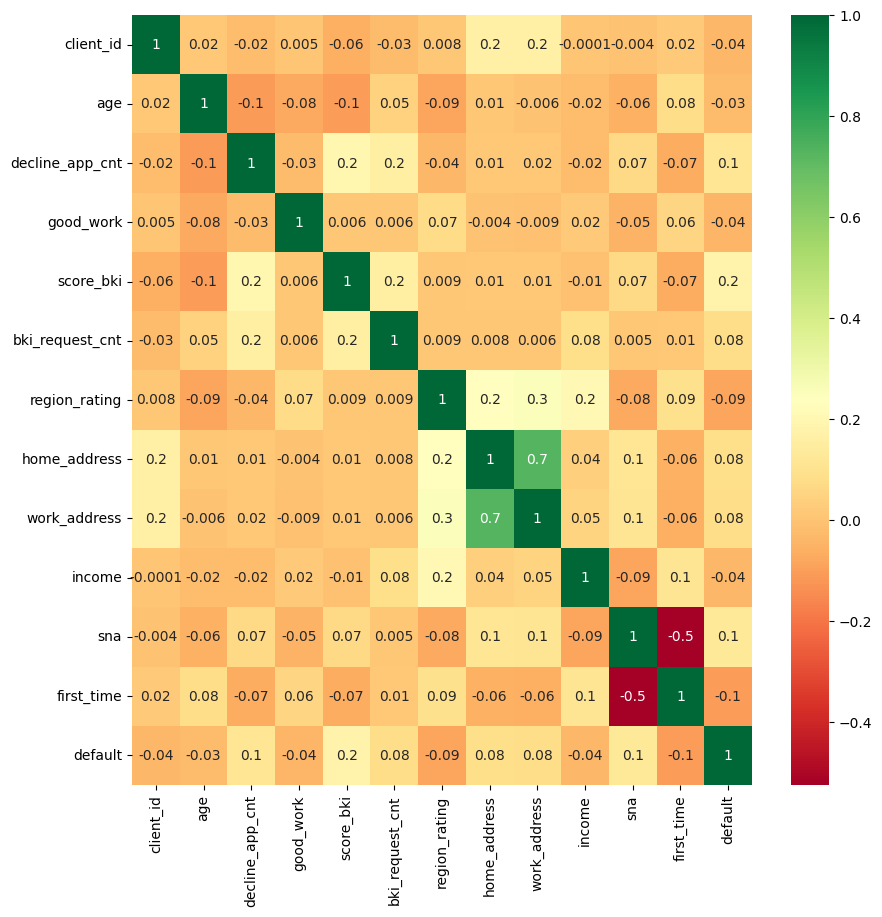

In [14]:
sb.heatmap(
    data.corr(),
    annot=True,
    cmap='RdYlGn',
    fmt='.1g',
)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

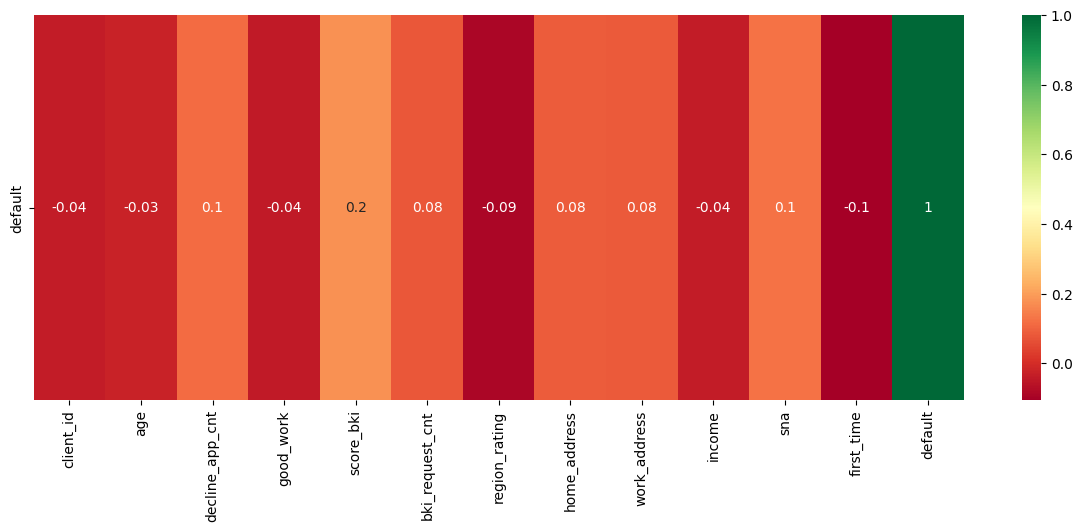

In [15]:
sb.heatmap(
    data.corr()[['default']].transpose(),
    annot=True,
    cmap='RdYlGn',
    fmt='.1g',
)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

## Обработка датасета

In [16]:
number_columns = [
    "client_id",
    "age",
    "score_bki",
    "bki_request_cnt",
    "region_rating",
    "income",
    "sna",
    "first_time",
]
category_columns = [
    "app_date",
    "education",
    "sex",
    "car",
    "car_type",
    "foreign_passport",
]
category_columns_encoded = [
    "decline_app_cnt",
    "good_work",
    "home_address",
    "work_address",
    "default",
]
data = set_type(data, {"category": category_columns})
x = formating_data(
    data,
    number_columns,
    category_columns,
    category_columns_encoded
)
num_0 = len(x[x['default']==0]) // 10
x = pd.concat([x[x['default']==0].sample(num_0) , x[x['default']==1]])
x["default"] = x["default"].replace({0: 1, 1: 0})
y = x.pop("default")
smote = SMOTE()
x, y = smote.fit_resample(x, y)

In [17]:
feat_selector = BorutaPy(
    estimator=RandomForestClassifier(
        n_jobs=-1,
        n_estimators=5000,
        max_depth=10,
        random_state=STATE,
        criterion="log_loss",
        bootstrap=False,
    ),
)

In [18]:
feat_selector.fit(np.array(x), np.array(y))

BorutaPy(estimator=RandomForestClassifier(bootstrap=False, criterion='log_loss',
                                          max_depth=10, n_estimators=1000,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1FC1EFFC140),
         random_state=RandomState(MT19937) at 0x1FC1EFFC140)

In [19]:
x.drop(
    [
        x.columns[i]
        for i in range(len(feat_selector.support_))
        if not feat_selector.support_[i]
    ],
    axis=1,
    inplace=True,
)

In [20]:
x

,education_GRD,education_SCH,decline_app_cnt,home_address,work_address,client_id,age,score_bki,bki_request_cnt,region_rating,income,sna,first_time
0,0,1,0,2,3,0.958419,0.215686,0.387022,0.000000,1.000000,0.039039,0.000000,0.333333
1,0,0,0,2,3,0.216504,0.254902,0.696053,0.018868,1.000000,0.299299,1.000000,0.000000
2,1,0,0,2,3,0.776660,0.647059,0.453283,0.075472,0.833333,0.049049,0.000000,0.333333
3,0,1,0,2,3,0.864979,0.078431,0.533064,0.037736,0.833333,0.029029,0.333333,0.333333
4,0,1,0,2,3,0.026528,0.333333,0.269725,0.000000,1.000000,0.024024,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18739,0,0,0,2,3,0.645374,0.072989,0.478399,0.298945,0.536122,0.094989,0.000000,0.357414
18740,0,0,0,1,2,0.154831,0.398118,0.512962,0.103208,0.649000,0.018701,0.000000,0.035333
18741,0,1,0,1,3,0.780300,0.226258,0.466840,0.008696,0.410144,0.049833,0.153621,0.666667
18742,0,0,1,2,3,0.693842,0.095686,0.535070,0.042264,0.393331,0.029029,0.000000,0.960001


In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=0.7,
    shuffle=True,
    random_state=STATE,
)

## Создадим объекты классификаторов и обучим их четырьмя разными вариантами

**Классификация методом опорных векторов**

In [22]:
svc_parameters = {
    "kernel": [
        "linear",
        "poly",
        "rbf",
        "sigmoid",
    ],
    "C": [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
}
svc_grid = GridSearchHyperParametersModel(
    MethodNames.GRID.value,
    ModelNames.SVC_MODEL.value,
    SVC(probability=True, random_state=STATE),
    svc_parameters,
)
svc_randomized = RandomizedSearchHyperParametersModel(
    MethodNames.RANDOMIZED.value,
    ModelNames.SVC_MODEL.value,
    SVC(probability=True, random_state=STATE),
    svc_parameters,
)
svc_bayes = BayesSearchHyperParametersModel(
    MethodNames.BAYES.value,
    ModelNames.SVC_MODEL.value,
    SVC(probability=True, random_state=STATE),
    svc_parameters,
)
svc_genetic = GeneticAlgorithmsHyperParametersModel(
    MethodNames.GENETIC.value,
    ModelNames.SVC_MODEL.value,
    SVC(probability=True, random_state=STATE),
    convert_parameters(svc_parameters),
)
svc_models = [
    svc_grid,
    svc_randomized,
    svc_bayes,
    svc_genetic,
]

**Классификация методом ближайших соседей**

In [23]:
knn_parameters = {
    "n_neighbors": list(range(1, 31)),
    "weights": [
        "uniform",
        "distance",
    ],
    "algorithm": [
        "auto",
        "ball_tree",
        "kd_tree",
        "brute",
    ],
}
knn_grid = GridSearchHyperParametersModel(
    MethodNames.GRID.value,
    ModelNames.KNN_MODEL.value,
    KNeighborsClassifier(n_jobs=-1),
    knn_parameters,
)
knn_randomized = RandomizedSearchHyperParametersModel(
    MethodNames.RANDOMIZED.value,
    ModelNames.KNN_MODEL.value,
    KNeighborsClassifier(n_jobs=-1),
    knn_parameters,
)
knn_bayes = BayesSearchHyperParametersModel(
    MethodNames.BAYES.value,
    ModelNames.KNN_MODEL.value,
    KNeighborsClassifier(n_jobs=-1),
    knn_parameters,
)
knn_genetic = GeneticAlgorithmsHyperParametersModel(
    MethodNames.GENETIC.value,
    ModelNames.KNN_MODEL.value,
    KNeighborsClassifier(n_jobs=-1),
    convert_parameters(knn_parameters),
)
knn_models = [
    knn_grid,
    knn_randomized,
    knn_bayes,
    knn_genetic,
]

**Классификация с помощью градиентного бустинга**

In [24]:
gradient_boosting_parameters = {
    "max_depth": MAX_DEPTH,
    "n_estimators": N_ESTIMATORS,
    "criterion": [
        "friedman_mse",
        "squared_error",
    ],
}
gradient_boosting_grid = GridSearchHyperParametersModel(
    MethodNames.GRID.value,
    ModelNames.GRADIENT_BOOSTING_CLASSIFIER.value,
    GradientBoostingClassifier(random_state=STATE),
    gradient_boosting_parameters,
)
gradient_boosting_randomized = RandomizedSearchHyperParametersModel(
    MethodNames.RANDOMIZED.value,
    ModelNames.GRADIENT_BOOSTING_CLASSIFIER.value,
    GradientBoostingClassifier(random_state=STATE),
    gradient_boosting_parameters,
)
gradient_boosting_bayes = BayesSearchHyperParametersModel(
    MethodNames.BAYES.value,
    ModelNames.GRADIENT_BOOSTING_CLASSIFIER.value,
    GradientBoostingClassifier(random_state=STATE),
    gradient_boosting_parameters,
)
gradient_boosting_genetic = GeneticAlgorithmsHyperParametersModel(
    MethodNames.GENETIC.value,
    ModelNames.GRADIENT_BOOSTING_CLASSIFIER.value,
    GradientBoostingClassifier(random_state=STATE),
    convert_parameters(gradient_boosting_parameters),
)
gradient_boosting_models = [
    gradient_boosting_grid,
    gradient_boosting_randomized,
    gradient_boosting_bayes,
    gradient_boosting_genetic,
]

**Классификация с помощью случайного леса**

In [25]:
random_forest_parameters = {
    "max_depth": MAX_DEPTH,
    "n_estimators": N_ESTIMATORS,
    "criterion": [
        "gini",
        "entropy",
        "log_loss",
    ],
    "bootstrap": [True, False],
}
random_forest_grid = GridSearchHyperParametersModel(
    MethodNames.GRID.value,
    ModelNames.RANDOM_FOREST_CLASSIFIER.value,
    RandomForestClassifier(random_state=STATE, n_jobs=-1),
    random_forest_parameters,
)
random_forest_randomized = RandomizedSearchHyperParametersModel(
    MethodNames.RANDOMIZED.value,
    ModelNames.RANDOM_FOREST_CLASSIFIER.value,
    RandomForestClassifier(random_state=STATE, n_jobs=-1),
    random_forest_parameters,
)
random_forest_bayes = BayesSearchHyperParametersModel(
    MethodNames.BAYES.value,
    ModelNames.RANDOM_FOREST_CLASSIFIER.value,
    RandomForestClassifier(random_state=STATE, n_jobs=-1),
    random_forest_parameters,
)
random_forest_genetic = GeneticAlgorithmsHyperParametersModel(
    MethodNames.GENETIC.value,
    ModelNames.RANDOM_FOREST_CLASSIFIER.value,
    RandomForestClassifier(random_state=STATE, n_jobs=-1),
    convert_parameters(random_forest_parameters),
)
random_forest_models = [
    random_forest_grid,
    random_forest_randomized,
    random_forest_bayes,
    random_forest_genetic,
]

## Обучение и результаты

### SVC 

In [26]:
for model in svc_models:
    model.fit_model(x_train, x_test, y_train, y_test)
    model.get_results()

Метод: Grid Search
Время обучения: 868.7990 секунд
F1 score: 0.6715
Accuracy score: 0.6775
ROC-AUC score: 0.7499
Recall score: 0.6737
Precision score: 0.6693
Параметры модели:
	kernel: rbf
	C: 5
Метод: Randomized Search
Время обучения: 231.2755 секунд
F1 score: 0.6713
Accuracy score: 0.6776
ROC-AUC score: 0.7500
Recall score: 0.6726
Precision score: 0.6699
Параметры модели:
	kernel: rbf
	C: 4
Метод: Bayes Search
Время обучения: 1352.8141 секунд
F1 score: 0.6715
Accuracy score: 0.6775
ROC-AUC score: 0.7499
Recall score: 0.6737
Precision score: 0.6693
Параметры модели:
	kernel: rbf
	C: 5.0
Метод: Genetic Algorithm
Время обучения: 4303.8110 секунд
F1 score: 0.6715
Accuracy score: 0.6775
ROC-AUC score: 0.7499
Recall score: 0.6737
Precision score: 0.6693
Параметры модели:
	kernel: rbf
	C: 5.0


### KNN

In [27]:
for model in knn_models:
    model.fit_model(x_train, x_test, y_train, y_test)
    model.get_results()

Метод: Grid Search
Время обучения: 72.8020 секунд
F1 score: 0.6900
Accuracy score: 0.6776
ROC-AUC score: 0.7462
Recall score: 0.7333
Precision score: 0.6516
Параметры модели:
	n_neighbors: 27
	weights: distance
	algorithm: auto
Метод: Randomized Search
Время обучения: 4.0880 секунд
F1 score: 0.6900
Accuracy score: 0.6776
ROC-AUC score: 0.7462
Recall score: 0.7333
Precision score: 0.6516
Параметры модели:
	n_neighbors: 27
	weights: distance
	algorithm: brute
Метод: Bayes Search
Время обучения: 80.7090 секунд
F1 score: 0.6900
Accuracy score: 0.6776
ROC-AUC score: 0.7462
Recall score: 0.7333
Precision score: 0.6516
Параметры модели:
	n_neighbors: 27
	weights: distance
	algorithm: kd_tree
Метод: Genetic Algorithm
Время обучения: 186.6025 секунд
F1 score: 0.6900
Accuracy score: 0.6776
ROC-AUC score: 0.7462
Recall score: 0.7333
Precision score: 0.6516
Параметры модели:
	n_neighbors: 27
	weights: distance
	algorithm: kd_tree


### Gradient Boosting

In [28]:
for model in gradient_boosting_models:
    model.fit_model(x_train, x_test, y_train, y_test)
    model.get_results()

Метод: Grid Search
Время обучения: 5909.6695 секунд
F1 score: 0.7199
Accuracy score: 0.7367
ROC-AUC score: 0.8162
Recall score: 0.6915
Precision score: 0.7507
Параметры модели:
	max_depth: 2
	n_estimators: 500
	criterion: squared_error
Метод: Randomized Search
Время обучения: 450.0260 секунд
F1 score: 0.7198
Accuracy score: 0.7365
ROC-AUC score: 0.8127
Recall score: 0.6919
Precision score: 0.7502
Параметры модели:
	max_depth: 4
	n_estimators: 100
	criterion: squared_error
Метод: Bayes Search
Время обучения: 1884.3342 секунд
F1 score: 0.7198
Accuracy score: 0.7365
ROC-AUC score: 0.8127
Recall score: 0.6919
Precision score: 0.7502
Параметры модели:
	max_depth: 4
	n_estimators: 100
	criterion: squared_error
Метод: Genetic Algorithm
Время обучения: 4826.4465 секунд
F1 score: 0.7194
Accuracy score: 0.7351
ROC-AUC score: 0.8120
Recall score: 0.6940
Precision score: 0.7467
Параметры модели:
	max_depth: 5
	n_estimators: 100
	criterion: friedman_mse


### Random Forest

In [29]:
for model in random_forest_models:
    model.fit_model(x_train, x_test, y_train, y_test)
    model.get_results()

Метод: Grid Search
Время обучения: 5691.8265 секунд
F1 score: 0.7165
Accuracy score: 0.7251
ROC-AUC score: 0.7995
Recall score: 0.7100
Precision score: 0.7232
Параметры модели:
	max_depth: 10
	n_estimators: 5000
	criterion: entropy
	bootstrap: True
Метод: Randomized Search
Время обучения: 154.7123 секунд
F1 score: 0.7161
Accuracy score: 0.7244
ROC-AUC score: 0.7988
Recall score: 0.7104
Precision score: 0.7219
Параметры модели:
	max_depth: 10
	n_estimators: 2000
	criterion: gini
	bootstrap: True
Метод: Bayes Search
Время обучения: 1099.9146 секунд
F1 score: 0.7165
Accuracy score: 0.7251
ROC-AUC score: 0.7995
Recall score: 0.7100
Precision score: 0.7232
Параметры модели:
	max_depth: 10
	n_estimators: 5000
	criterion: entropy
	bootstrap: True
Метод: Genetic Algorithm
Время обучения: 4577.2494 секунд
F1 score: 0.7165
Accuracy score: 0.7251
ROC-AUC score: 0.7995
Recall score: 0.7100
Precision score: 0.7232
Параметры модели:
	max_depth: 10
	n_estimators: 5000
	criterion: entropy
	bootstrap: 

### Итоговый график ROC-AUC

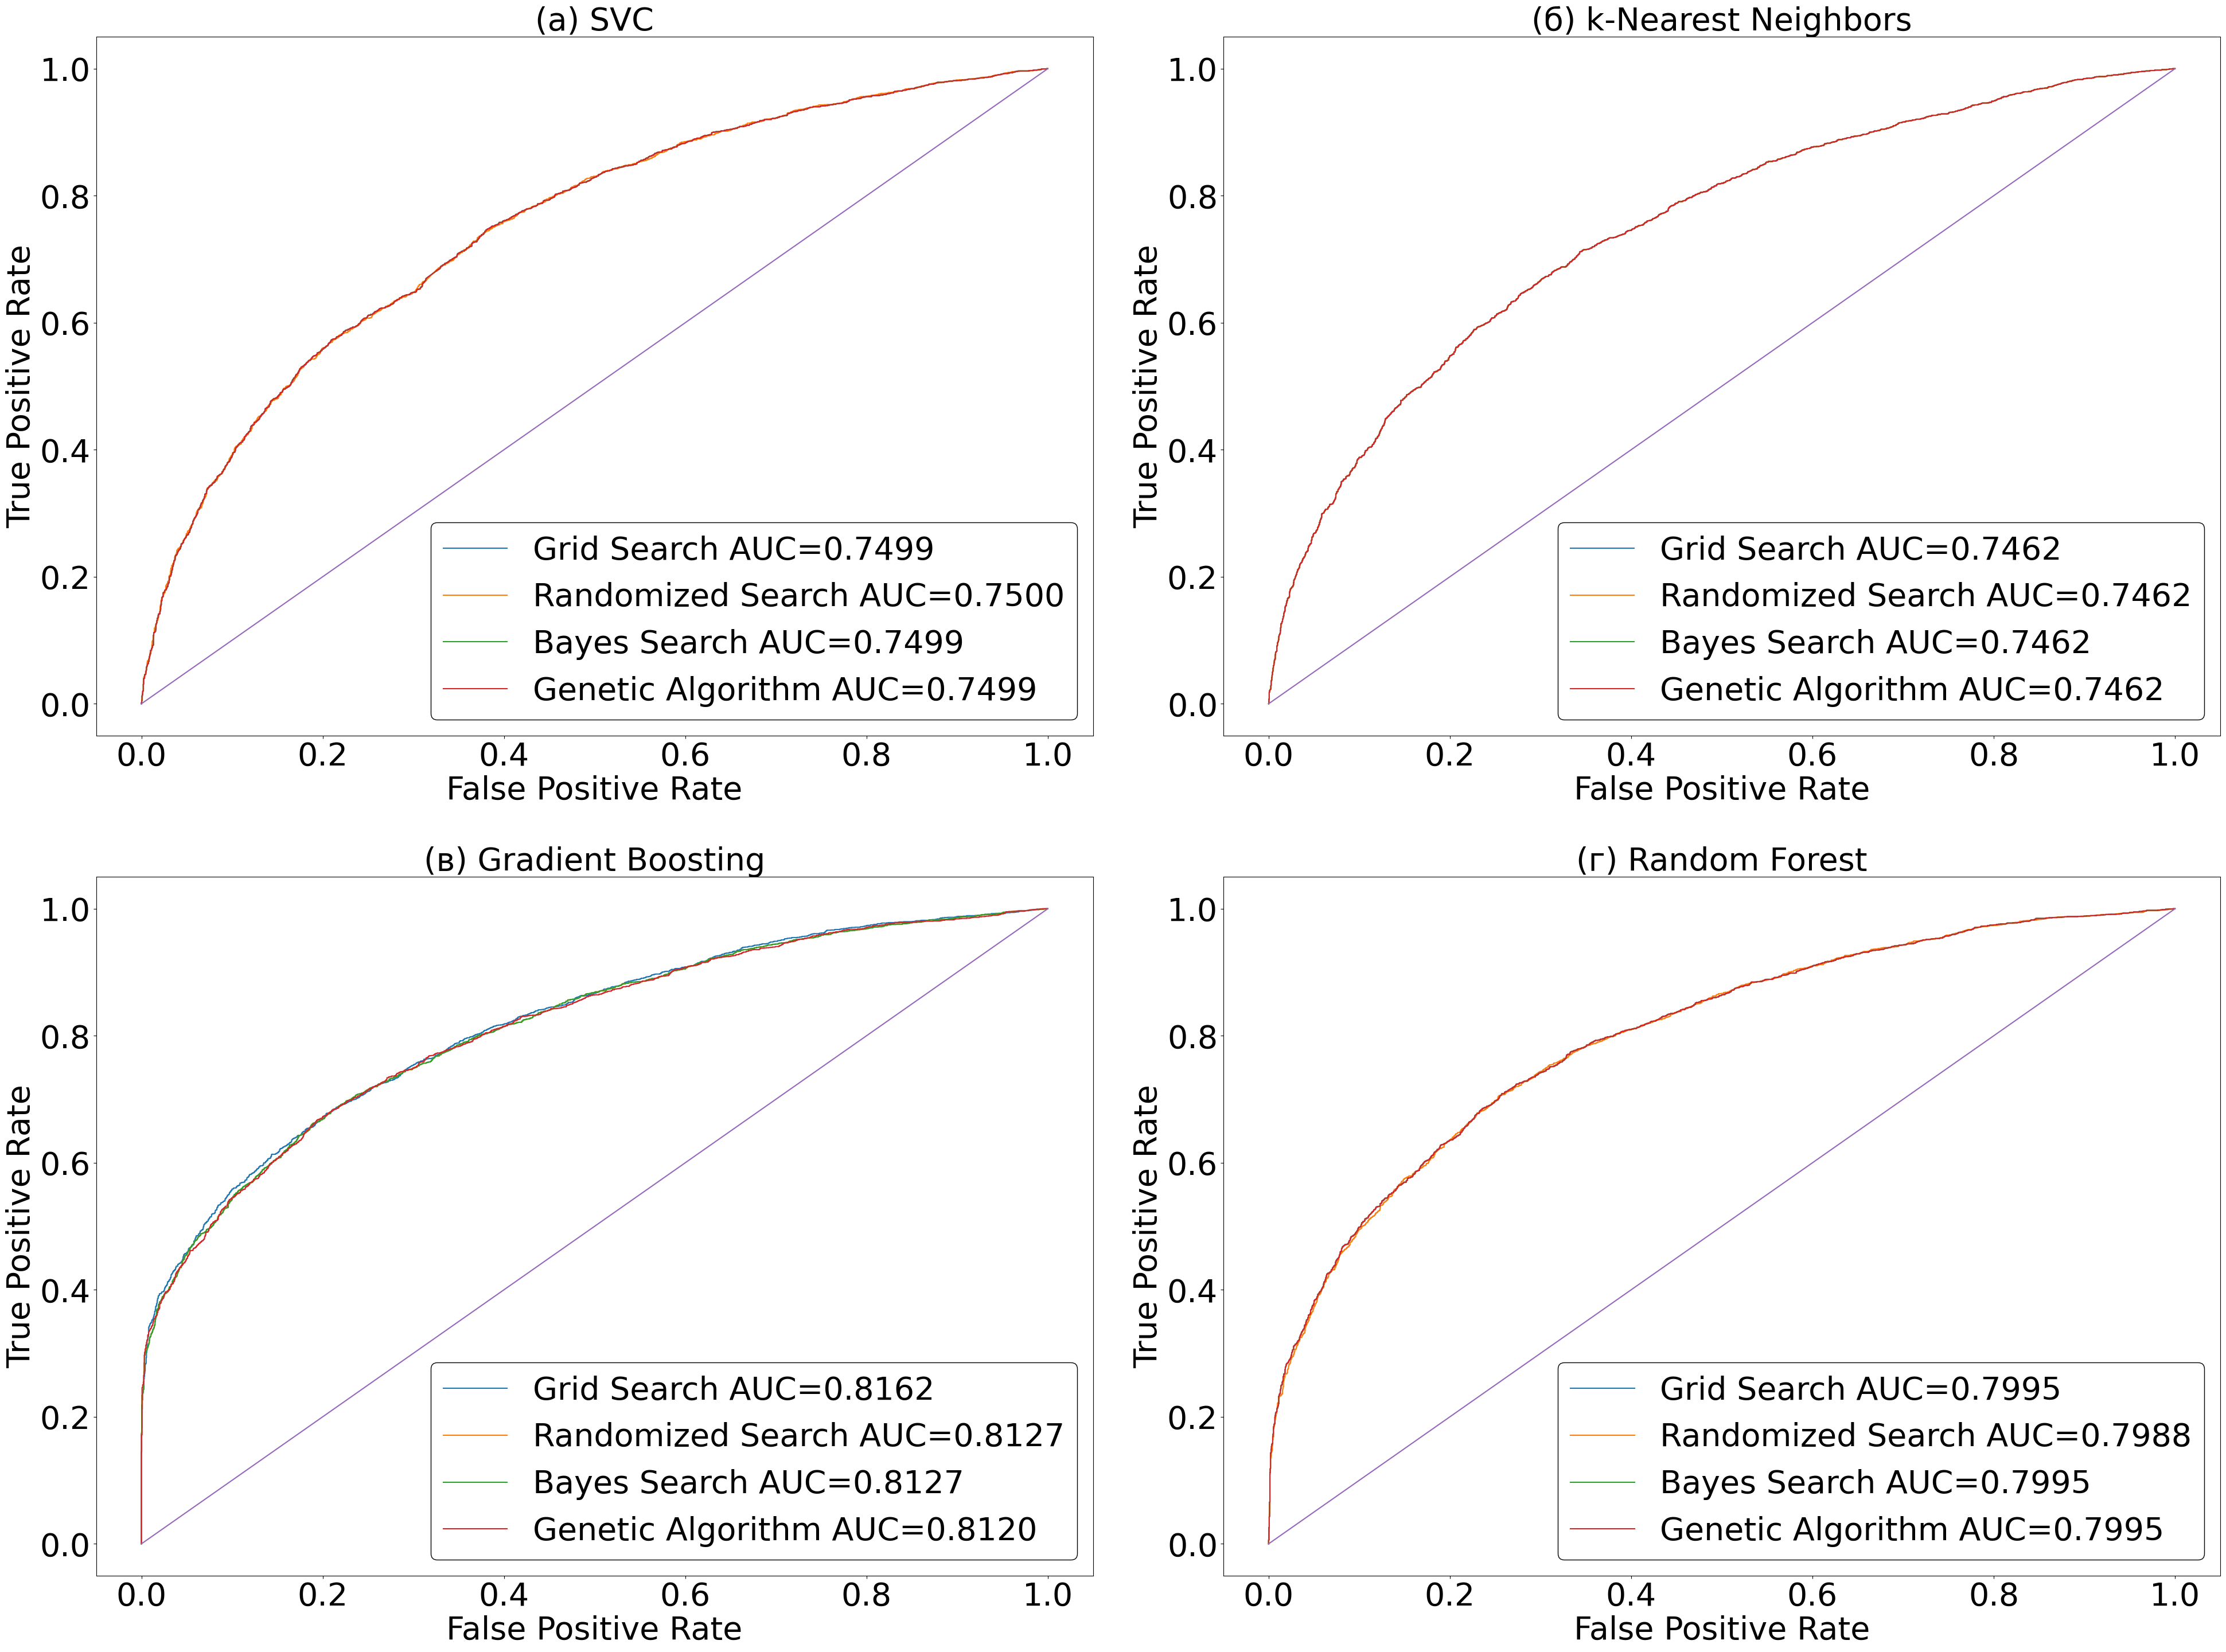

In [30]:
roc_auc_plot(
    [svc_models, knn_models, gradient_boosting_models, random_forest_models],
    y_test,
)